<a href="https://colab.research.google.com/github/stephenbeckr/numerical-analysis-class/blob/master/Demos/Ch1_Extra_Conditioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Extra"
This is a supplemental notebook, from Jed Brown's [CSCI 3656 Numerical Computation course](https://github.com/cu-numcomp/numcomp-class/).

  
Copyright (c) 2017-2020, Jed Brown
All rights reserved.

Redistribution and use in source and binary forms, with or without modification,
are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.
* Redistributions in binary form must reproduce the above copyright notice, this
  list of conditions and the following disclaimer in the documentation and/or
  other materials provided with the distribution.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR
ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
(INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON
ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
(INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

# Conditioning

We say that a mathematical function $f(x)$ is well conditioned if small changes in $x$ produce small changes in $f(x)$.
(What we mean by "small" will be made more precise.)
In this context, $f(x)$ may represent a simple expression such as

* $f(x) := 2 x$
* $f(x) := \sqrt{x}$
* $f(x) := \log{x}$
* $f(x) := x - 1$

but it may also represent a problem such as:

* Find the positive root of the polynomial $t^2 + (1-x)t - x.$
* Find the eigenvectors of the matrix
$$ A(x) = \begin{bmatrix} 1 & 1 \\ 0 & x \end{bmatrix} .$$
* Find the length of the rubber band when it finally snaps, as a function of temperature $x$ during manufacturing.
* Find the time at which the slope avalanches as a function of the wind speed $x$ during the storm.
* Find the probability that the slope avalanches in the next 48 hours as a function of the wind speed $x$ during the storm.
* Find the probability that the hurricane makes landfall as a function of the observations $x$.
* Find the shape of the tumor as a function of the received acoustic waves $x$ in an ultrasound scan.
* Find the lift and drag of the airplane wing as a function of its shape $x$.
* Find the stall speed of the airplane wing as a function of its shape $x$.
* Find the global mean temperature change as a function of the emissions profile $x$.
* Find the annual mean rainfall in the South Platte drainage basin as a function of the emissions profile $x$.

Some of these problems are fully-specified while others involve sophisticated models and ongoing community research problems.
In some cases, the models that are computable may incur greater uncertainty than the underlying system.
In such cases, an analog experiment might produce smoother variation of the output as the problem data $x$ are varied.
In others, the model might be better behaved than what it seeks to model.
Some of these problems may be ill-posed.

## Well-posedness

A problem is said to be [well-posed](https://en.wikipedia.org/wiki/Well-posed_problem) if
1. a solution exists,
2. the solution is unique, and
3. the solution depends continuously on the problem specification.

Mathematically, continuous variation in part 3 can be arbitrarily fast, but there may be measurement error, manufacturing tolerances, or incomplete specification in real-world problems, such that we need to quantify part 3.  This is the role of conditioning.

Let's explore conditioning by way of a rootfinding example.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np

We've observed algorithms struggle to compute roots accurately, especially when the roots have high multiplicity.  Difficulty computing zeros of polynomials can also arise when all the roots are simple, and it may be inherent to the problem, rather than a result of the numerical method.  For example, the Wilkinson polynomial
$$ \prod_{i=1}^{20} (x - i) = \sum_{i=0}^{20} a_i x^i $$
has roots at each of the positive integers up to 20.

In [2]:
def wilkinson(n):
    """Compute Wilkinson polynomial of degree n in the
    monomial basis p[0]*x^n + ... + p[n-1]*x + p[n].
    The polynomial can be evaluated using np.polyval(p,x)
    """
    p = np.array([1])
    for i in range(1, n+1):
        p = np.polymul(p, np.array([1, -i]))
    return p

wilkinson(10)

array([        1,       -55,      1320,    -18150,    157773,   -902055,
         3416930,  -8409500,  12753576, -10628640,   3628800])

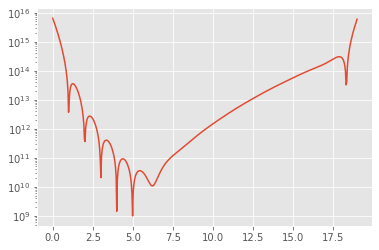

In [6]:
def plot_wilkinson(n):
    """Plot the Wilkinson polynomial of degree n."""
    p = wilkinson(n)
    p[n//2] *= 1 + 1e-10
    x = np.linspace(0, n+1, 500)
    y = np.polyval(p, x)
    #plt.plot(x, y)
    plt.semilogy(x, np.abs(y))
    
plot_wilkinson(18)

The roots are extremely sensitive to perturbations of the coefficients $a_i$, as shown in this figure from Trefethen and Bau (1999).
![Ill conditioning of roots of Wilkinson's polynomial](https://github.com/stephenbeckr/numerical-analysis-class/blob/master/Demos/img/TB-Wilkinson.png?raw=1)

Numerical difficulties in which "correct" algorithms produce unreliable solutions almost always stem from lack of *stability* and/or *ill conditioning*.

### Absolute condition number
Consider a function $f: X \to Y$ and define the *absolute condition number*
$$ \hat\kappa = \lim_{\delta \to 0} \max_{|\delta x| < \delta} \frac{|f(x + \delta x) - f(x)|}{|\delta x|} = \max_{\delta x} \frac{|\delta f|}{|\delta x|}. $$
If $f$ is differentiable, then $\hat\kappa = |f'(x)|$.

### Floating point arithmetic
Floating point arithmetic $x \circledast y := \text{float}(x * y)$ is exact within a relative accuracy $\epsilon_{\text{machine}}$.  Formally,
$$ x \circledast y = (x * y) (1 + \epsilon) $$
for some $|\epsilon| \le \epsilon_{\text{machine}}$.

In [9]:
print(format(1/3, '.20f'))
print(format(.2 - 1/3 + 2/15, '.20f'))
print(format((.2 - 1/3) + (1/3 - 0.2), '.20f'))
print(format((1 + 1e-12) - 1, '.20f'))
print(format(1e-12 + 1 - 1, '.20f'))

0.33333333333333331483
0.00000000000000002776
0.00000000000000000000
0.00000000000100008890
0.00000000000100008890


In [10]:
eps = 1
while 1 + eps > 1:
    eps /= 2
eps_machine = eps
print('Machine epsilon = {}'.format(eps_machine))
(1 + 1.12e-16) - 1

Machine epsilon = 1.1102230246251565e-16


2.220446049250313e-16

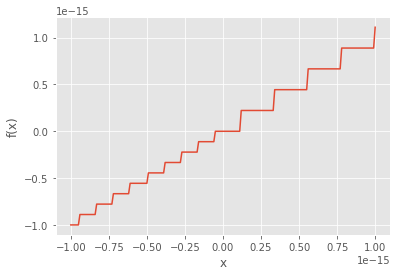

In [ ]:
def plot_neighborhood(f, x0, atol=1e-10, rtol=1e-10):
    width = atol + rtol * np.abs(x0)
    x = np.linspace(x0 - width, x0 + width, 201)
    plt.plot(x, f(x))
    plt.xlabel('x')
    plt.ylabel('f(x)')

plot_neighborhood(lambda x: (x + 1) - 1, 0, 1e-15)

This function $f(x) = (x + 1) - 1 = x$ is well conditioned for all $x$, but this numerical algorithm is unstable (we'll discuss this below).

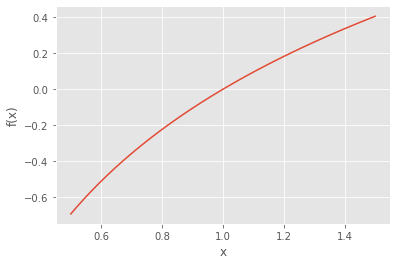

In [ ]:
plot_neighborhood(np.log, 1, .5)

The function $f(x) = \log x$ has $f'(1) = 1$.  The conditioning is good in an absolute sense, $\hat \kappa = 1$.  However, the outputs from `np.log(1+x)` have large relative error relative to the exact value, provided here by the function `np.log1p(x)`.

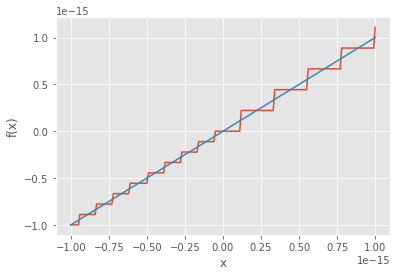

In [ ]:
plot_neighborhood(lambda x: np.log(1+x), 0, atol=1e-15)
plot_neighborhood(np.log1p, 0, atol=1e-15)

In [ ]:
np.log(1 + 1e-12) - np.log1p(1e-12)

8.890058234103173e-17

In [ ]:
(np.log(1 + 1e-12) - np.log1p(1e-12)) / np.log1p(1e-12)

8.890058234107618e-05

In [ ]:
x = np.array([1,1e5,1e10,1e15])
np.sin(np.pi*x)

array([ 1.22464680e-16, -3.39606540e-11, -2.23936276e-06, -2.36209053e-01])

In [ ]:
np.sin(x)**2 + np.cos(x)**2 - 1

array([ 0.00000000e+00, -1.11022302e-16,  0.00000000e+00,  0.00000000e+00])

### Relative condition number

Given the relative nature of floating point arithmetic, it is more useful to discuss **relative condition number**,
$$ \kappa = \max_{\delta x} \frac{|\delta f|/|f|}{|\delta x|/|x|}
= \max_{\delta x} \Big[ \frac{|\delta f|/|\delta x|}{|f| / |x|} \Big] $$
or, if $f$ is differentiable,
$$ \kappa = |f'(x)| \frac{|x|}{|f|} . $$

How does a condition number get big?

## Stability

We use the notation $\tilde f(x)$ to mean a numerical algorithm for approximating $f(x)$.  Additionally, $\tilde x = x (1 + \epsilon)$ is some "good" approximation of the exact input $x$.

### Stability
**"nearly the right answer to nearly the right question"**
$$ \frac{\lvert \tilde f(x) - f(\tilde x) \rvert}{| f(\tilde x) |} \in O(\epsilon_{\text{machine}}) $$
for some $\tilde x$ that is close to $x$

### Backward Stability
**"exactly the right answer to nearly the right question"**
$$ \tilde f(x) = f(\tilde x) $$
for some $\tilde x$ that is close to $x$

* Every backward stable algorithm is stable.
* Not every stable algorithm is backward stable.

### Accuracy of backward stable algorithms (Theorem)

A backward stable algorithm for computing $f(x)$ has relative accuracy
$$ \left\lvert \frac{\tilde f(x) - f(x)}{f(x)} \right\rvert \in O(\kappa(f) \epsilon_{\text{machine}}) . $$
Backward stability is generally the best we can hope for.

In practice, it is rarely possible for a function to be backward stable when the output space is higher dimensional than the input space.

# Beyond IEEE-754 double precision

## Lower precision IEEE-754 and relatives

The default floating point type in Python is `double` precision, which requires 8 bytes (64 bits) to store and offers $\epsilon_{\text{machine}} \approx 10^{-16}$.

* IEEE-754 **single precision** (`float` in C and related languages) is half the size (4 bytes = 32 bits) and has long been popular when adequate.
* IEEE-754 **half precision** reduces both range (exponent bits) and precision (mantissa) bits.
* **bfloat16** is a relatively new non-IEEE type that is popular in machine learning because it's easy to convert to/from single precision (just truncate/round the mantissa).

| Type | $\epsilon_{\text{machine}}$ | exponent bits | mantissa bits | diagram |
|-----|-----|---|---|---|
| double | 1.11e-16 | 11 | 52 | |
| single | 5.96e-8 | 8 | 23 | ![](https://upload.wikimedia.org/wikipedia/commons/d/d2/Float_example.svg) |
| [half](https://en.wikipedia.org/wiki/Half-precision_floating-point_format) | 4.88e-4 | 5 | 10 | ![](https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/IEEE_754r_Half_Floating_Point_Format.svg/350px-IEEE_754r_Half_Floating_Point_Format.svg.png) |
| [bfloat16](https://en.wikipedia.org/wiki/Bfloat16_floating-point_format) | 3.91e-3 | 8 | 7 | ![](https://upload.wikimedia.org/wikipedia/commons/0/0b/Bfloat16_format.svg) |


### Mixed-precision algorithms

Sometimes reducing the precision (from double to single, or from single to half) compromises the quality of results (due to ill-conditioning or poor stability), but one can recover accurate results by using higher precision in a small fraction of the computation.  These are *mixed-precision algorithms*, and can be a useful optimization technique.  Such techniques can give up to 2x improvement if memory bandwidth (for floating point data) or pure vectorizable flops are the bottleneck.  In case of single to half precision, the benefit can be greater than 2x when using special hardware, such as GPUs with "tensor cores".

Warning: Premature use of mixed-precision techniques can often obscure better algorithms that can provide greater speedups and/or reliability improvements.